# Emotional Status -  Modeling
Author: Sicong Zhao

In [0]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd

## 1.Load Data

In [0]:
# Load data
roo = pd.read_csv('exp_roo_steps_sleep.csv', index_col='Unnamed: 0')

In [79]:
roo.tail()

,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,DATE,ID,Experiment,mean,var,median,move_rate,active_rate,very_active_rate,running_rate,subject,la_p,ha_p,ha_n,la_n,la,p,n,ha,start_survey,survey_no,start_survey_30m_ahead,start_survey_3h_ahead,survey_date,intercept
1118,2015-07-07 00:00:00,440,20,9,474,707,1004,R00,20.872928,574.400430,12.0,0.646409,0.530387,0.386740,0.281768,1004,2,0,0,0,1,1,1,0,2015-07-07 12:41:00,15,2015-07-07 12:11:00,2015-07-07 09:41:00,2015-07-07 00:00:00,1
1119,2015-07-08 00:00:00,74,7,4,86,708,1004,R00,7.616667,450.774022,0.0,0.211111,0.172222,0.122222,0.083333,1004,1,2,1,3,1,1,0,1,2015-07-08 09:02:37,16,2015-07-08 08:32:37,2015-07-08 06:02:37,2015-07-08 00:00:00,1
1120,2015-07-09 00:00:00,184,5,5,194,709,1004,R00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1004,1,0,1,2,1,0,1,0,2015-07-09 03:41:08,17,2015-07-09 03:11:08,2015-07-09 00:41:08,2015-07-09 00:00:00,1
1121,2015-07-09 00:00:00,184,5,5,194,709,1004,R00,0.511111,8.262446,0.0,0.050000,0.011111,0.005556,0.005556,1004,0,1,0,2,0,1,1,0,2015-07-09 09:16:06,18,2015-07-09 08:46:06,2015-07-09 06:16:06,2015-07-09 00:00:00,1
1122,2015-07-09 00:00:00,184,5,5,194,709,1004,R00,31.055556,2847.873991,0.0,0.372222,0.344444,0.311111,0.283333,1004,0,0,0,1,1,0,3,0,2015-07-09 14:47:53,19,2015-07-09 14:17:53,2015-07-09 11:47:53,2015-07-09 00:00:00,1


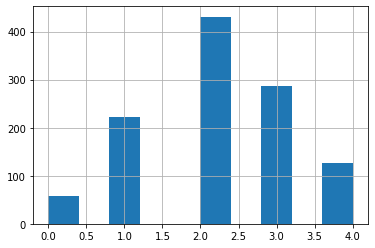

In [118]:
# Observe the distribution of 'p', the outcome of the first model
roo['p'].hist()

## 2.Data Pre-processing

In [0]:
# Extract features and the label
X = roo[['Minutes Asleep','Minutes Awake', 'Number of Awakenings', 
               'Time in Bed', 'mean', 'var','move_rate', 'active_rate', 
               'very_active_rate', 'running_rate']].values
y = roo['p'].values

In [0]:
# Split training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [0]:
# transform it into a specific format that XGBoost can handle. 
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

## 3.Modeling

In [0]:
# 4 Sets of Model Params
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 5,
    'gamma': 0.4} 

param_2 = {
    'eta': 0.01, 
    'max_depth': 10,  
    'objective': 'multi:softprob',  
    'num_class': 5,
    'gamma': 0.4} 

param_3 = {
    'eta': 0.01, 
    'max_depth': 6,  
    'objective': 'multi:softprob',  
    'num_class': 5,
    'gamma': 0.4} 

param_4 = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 5} 

steps = 1000  # The number of training iterations

In [0]:
# Modeling
model_roo_1 = xgb.train(param, D_train, steps)
model_roo_2 = xgb.train(param_2, D_train, steps)
model_roo_3 = xgb.train(param_3, D_train, steps)
model_roo_4 = xgb.train(param_4, D_train, steps)

## 4.Evaluation

In [108]:
# Evaluate the performance
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

model_list = [model_roo_1,model_roo_2,model_roo_3,model_roo_4]
for i in range(4):
  print(i, 'th model')
  preds = model_list[i].predict(D_test)
  best_preds = np.asarray([np.argmax(line) for line in preds])

  print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
  print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
  print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

0 th model
Precision = 0.4731309216192937
Recall = 0.3822747292814466
Accuracy = 0.5022222222222222
1 th model
Precision = 0.46210693295885996
Recall = 0.40194525904203326
Accuracy = 0.5111111111111111
2 th model
Precision = 0.47985707199616323
Recall = 0.3997492008741732
Accuracy = 0.52
3 th model
Precision = 0.5179740344914963
Recall = 0.4694327716524513
Accuracy = 0.5822222222222222


## 5. Search for Best Params

In [73]:
# Fine tune
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.01, 0.03, 0.05 ] ,
     "max_depth"        : [ 15, 17, 20, 24],
     "min_child_weight" : [ 1 ],
     "gamma"            : [ 0.4, 0.5, 0.6, 0.7, 0.8 ],
     "colsample_bytree" : [ 0.1, 0.2, 0.3 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.1, 0.2, 0.3],
                         'eta': [0.01, 0.03, 0.05],
                         'gamma': [0.4, 0.5, 0.6, 0.7, 0.8],
     

In [74]:
grid.best_params_
# model.dump_model('dump.raw.txt')

{'colsample_bytree': 0.1,
 'eta': 0.01,
 'gamma': 0.4,
 'max_depth': 24,
 'min_child_weight': 1}

## 6. Predict with the best model (overfitting detected)

In [71]:
preds = grid.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

Precision = 0.008888888888888889
Recall = 0.2
Accuracy = 0.044444444444444446


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
grid.best_score_

-1.3272685173694605

In [0]:
grid.best_score_

In [126]:
for i in range(5):
  res = sum(best_preds == i)/len(best_preds)
  print(i, res)

0 0.02666666666666667
1 0.1688888888888889
2 0.47555555555555556
3 0.24444444444444444
4 0.08444444444444445


In [128]:
for i in range(5):
  res = sum(Y_test == i)/len(Y_test)
  print(i, res)

0 0.044444444444444446
1 0.2088888888888889
2 0.37333333333333335
3 0.24444444444444444
4 0.1288888888888889
